In [2]:
from utility_funcs import fix_date_time
import pandas as pd
import numpy as np
import seaborn as sn
import scipy as sp
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from sklearn.naive_bayes import MultinomialNB
from math import pow, sqrt
from scipy.stats import mannwhitneyu, binom_test, chisquare, chi2_contingency

In [3]:
filepath = 'test_results.csv'
outpath = 'fixed_test_results.csv'
# fix_date_time(filepath=filepath, outpath=outpath)

In [4]:
test_df = pd.DataFrame.from_csv('fixed_test_results.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
user_df = pd.DataFrame.from_csv('user_table.csv')

In [5]:
where_control = test_df.where(test_df['test'] == 0)
where_test = test_df.where(test_df['test'] == 1)
invalid_control = ~((where_control['price'] == 39) | pd.isnull(where_control['price']))
invalid_test = ~((where_test['price'] == 59) | pd.isnull(where_test['price']))
valid_test_or_control = ~(invalid_control | invalid_test)
dropped_invalid_df = test_df.where(~valid_test_or_control).dropna(how='all')
test_df = test_df.where(valid_test_or_control).dropna(how='all')
test_df.reset_index(level=0, inplace=True)
user_df.reset_index(level=0, inplace=True)
df = test_df.merge(user_df, on='user_id')
df.test = df.test.astype(int)
df.converted = df.converted.astype(int)

In [6]:
# df.timestamp.dt.minute
# df.timestamp.dt.month
# df.timestamp.dt.hour
df.columns
admin1 = []
admin2 = []
country = []
user_id = df.user_id
geosearch = rg.search(list(zip(df.lat, df.long)))
weird = ['Nunavut', 'St.-Petersburg', ]
index = 0
for item in geosearch:
    admin1.append(item['admin1'])
    admin2.append(item['admin2'])
    country.append(item['cc'])
    # if item['admin1'] in weird:
    #     print(item)
geocode_df = pd.DataFrame()
geocode_df['user_id']=user_id
admin1 = pd.Series(admin1)
admin2 = pd.Series(admin2)
country = pd.Series(country)
# admin1.unique()
# df[['lat', 'long']]
geocode_df['State'] = admin1
geocode_df['rg_country'] = country

combdf = df.merge(geocode_df, on=['user_id'])
non_usa = combdf.where(combdf['rg_country'] != 'US').dropna(how='all').copy()
fixeddf = combdf.where(combdf['rg_country'] == 'US').dropna(how='all').copy()
print(fixeddf.shape)
print(non_usa.shape)
# st_l = fixeddf.State.unique()
# for st in ["Alabama", "Alaska", "Arizona", "Arkansas",  "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]:
#     if st not in st_l:
#         print(st)
fixeddf['city_state'] = fixeddf.city.map(str) + '_' + fixeddf.State
df = fixeddf
df['hour_of_day'] = df.timestamp.dt.hour
df['month_of_year'] = df.timestamp.dt.month

Loading formatted geocoded file...
(274765, 14)
(529, 14)


In [7]:
df.loc()[0:20]

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,State,rg_country,city_state,hour_of_day,month_of_year
0,604839.0,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0.0,39.0,0.0,Buffalo,USA,42.89,-78.86,New York,US,Buffalo_New York,3,5
1,624057.0,2015-05-10 21:08:46,seo-google,mobile,android,0.0,39.0,0.0,Lakeville,USA,44.68,-93.24,Minnesota,US,Lakeville_Minnesota,21,5
2,317970.0,2015-04-04 15:01:23,ads-bing,mobile,android,0.0,39.0,0.0,Parma,USA,41.38,-81.73,Ohio,US,Parma_Ohio,15,4
3,685636.0,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1.0,59.0,0.0,Fayetteville,USA,35.07,-78.90,North Carolina,US,Fayetteville_North Carolina,7,5
4,820854.0,2015-05-24 11:04:40,ads_facebook,web,mac,0.0,39.0,0.0,Fishers,USA,39.95,-86.02,Indiana,US,Fishers_Indiana,11,5
5,169971.0,2015-04-13 12:07:08,ads-google,mobile,iOS,0.0,39.0,0.0,New York,USA,40.67,-73.94,New York,US,New York_New York,12,4
6,798371.0,2015-03-15 08:19:29,ads-bing,mobile,android,1.0,59.0,1.0,East Orange,USA,40.77,-74.21,New Jersey,US,East Orange_New Jersey,8,3
7,447194.0,2015-03-28 12:28:10,ads_facebook,web,windows,1.0,59.0,0.0,Dayton,USA,39.78,-84.20,Ohio,US,Dayton_Ohio,12,3
8,431639.0,2015-04-24 12:42:18,ads_facebook,web,windows,1.0,59.0,0.0,Richmond,USA,37.53,-77.47,Virginia,US,Richmond_Virginia,12,4
9,590182.0,2015-04-17 13:30:04,ads-google,web,windows,0.0,39.0,0.0,Bloomfield Township,USA,42.58,-83.27,Michigan,US,Bloomfield Township_Michigan,13,4


In [94]:
def compute_results_features(df):
    results_df = pd.DataFrame()
    results_df['class'] = pd.Series(['Control', 'Test'])
    results_df['Visitors'] = df.groupby(['test'])['user_id'].count()
    results_df['CountConverted'] = df.groupby(df['test'])['converted'].sum()
    results_df['CountUnconverted'] = results_df.Visitors - results_df.CountConverted
    results_df['SalesRevenue'] = df.groupby(['test'])['price'].sum()
    results_df['ConvertRate'] = results_df.CountConverted / results_df.Visitors
    results_df['price'] = pd.Series([39, 59])
    results_df['RevenueRate'] = results_df.ConvertRate * results_df.price
    results_df['sigma_rate']= np.sqrt((results_df.ConvertRate * (1 - results_df.ConvertRate)) / results_df.Visitors)
    results_df.set_index(['class'], inplace=True)
    return results_df


results_df = compute_results_features(df)
results_df

,Visitors,CountConverted,CountUnconverted,SalesRevenue,ConvertRate,price,RevenueRate,sigma_rate
class,,,,,,,,
Control,175933,3482.0,172451.0,6861387.0,0.019792,39,0.771873,0.000332
Test,98832,1526.0,97306.0,5831088.0,0.015440,59,0.910980,0.000392


In [9]:
def test_results_distros(results_df):
    converts = results_df.CountConverted
    nonconverts = results_df.Visitors - results_df.CountConverted
    rates = results_df.ConvertRate
    print("binomial test same rates: control: %0.3e, test: %0.3e" % (
        binom_test([converts[0], nonconverts[0]], p=rates[0]), 
     binom_test([converts[1], nonconverts[1]], p=rates[1])))
    print("binomial test, opposite rates: %0.3e, test: %0.3e" % (
        binom_test([converts[0], nonconverts[0]], p=rates[1]), 
     binom_test([converts[1], nonconverts[1]], p=rates[0])))
    # mannwhitneyu(df.where(df.test == 1).dropna(how='all').converted, 
    #              df.where(df.test == 0).dropna(how='all').converted)
    
    chidf = pd.DataFrame()
    chidf['success'] = converts
    chidf['failure'] = nonconverts
    chiresultdf = pd.DataFrame()
    chires = chi2_contingency(chidf)
    restbl = chires[3]
    chiresultdf['class'] = ['Control', 'Test']
    chiresultdf.set_index(['class'], inplace=True)
    chiresultdf['success'] = [restbl[0][0], restbl[1][0]]
    chiresultdf['failure'] = [restbl[0][1], restbl[1][1]]
    print("statistic: %0.3f\np=%0.3e\ndeg_free:%d\nexpected: %s" % (chires[0], chires[1], chires[2], chiresultdf))
test_results_distros(results_df)

binomial test same rates: control: 1.000e+00, test: 1.000e+00
binomial test, opposite rates: 1.065e-45, test: 2.114e-24
statistic: 66.715
p=3.137e-16
deg_free:1
expected:              success        failure
class                              
Control  3206.640089  172726.359911
Test     1801.359911   97030.640089


# ChiSQ Test indicates populations are drawn from different distributions

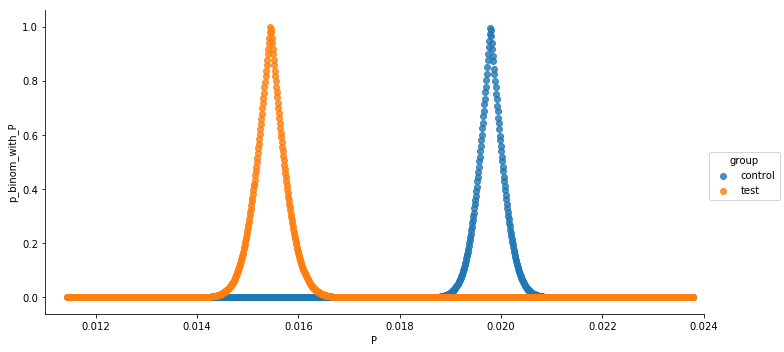

In [57]:
from floatrange import floatrange
from math import log10
def plot_dist_p_probs(results_df, factor=3):
    converts = results_df.CountConverted
    nonconverts = results_df.Visitors - results_df.CountConverted
    rates = results_df.ConvertRate
    xval = []
    cy = []
    vy = []
    range_buff = 0.004
    for f in floatrange(min(rates)-range_buff, max(rates)+range_buff, (10 ** (int(log10(min(rates))) - factor))):
        xval.append(f)
        cy.append(binom_test([converts[0], nonconverts[0]], p=f))
        vy.append(binom_test([converts[1], nonconverts[1]], p=f))
    cprobs = pd.DataFrame()
    cprobs['P']=xval
    cprobs['p_binom_with_P'] = cy
    cprobs['group'] = 'control'
    vprobs = pd.DataFrame()
    vprobs['P']=xval
    vprobs['p_binom_with_P'] = vy
    vprobs['group'] = 'test'
    probs = pd.concat([cprobs, vprobs])
#     return probs
    facets = sn.lmplot(x='P', y='p_binom_with_P', data=probs, hue='group', fit_reg=False, aspect=2)
    facets.ax.set_xlim([0.015-range_buff,0.020+range_buff])
    plt.show()
plot_dist_p_probs(results_df, 4)

# Additional Visual Support for difference in distributions.

In [82]:
control_price = 39
test_price = 59
conversion_rate =  results_df.CountConverted[0] / results_df.Visitors[0]
actual_new_rate = results_df.CountConverted[1] / results_df.Visitors[1]
#newConvRate = price*rate/new_rate
break_even = (control_price * conversion_rate) / test_price 
rate_diff = break_even - conversion_rate

print("control rate:               ", conversion_rate)
print("test rate:                  ", actual_new_rate)
print("break even value:           ", break_even) 
print("control rate * price:       ", conversion_rate * control_price)
print("test rate * test price:       ", actual_new_rate * test_price)
print("break even, percent change: ", (break_even - conversion_rate) / conversion_rate)
print("test rate percent change:   ", (actual_new_rate - conversion_rate) / conversion_rate)
print("break even rate difference: ", rate_diff)
print("test rate difference:       ", actual_new_rate - conversion_rate)
# results_df

control rate:                0.019791625221
test rate:                   0.0154403432087
break even value:            0.0130825997223
control rate * price:        0.771873383618
test rate * test price:        0.910980249312
break even, percent change:  -0.338983050847
test rate percent change:    -0.219854709439
break even rate difference:  -0.00670902549863
test rate difference:        -0.00435128201229


# important values calculated from rates and prices

In [111]:
from pandas.tseries.offsets import DateOffset
def get_weeks_for_sampsize(sampsize: int):
    start = min(df.timestamp.dt.date.unique())
    current = start
    end = max(df.timestamp.dt.date.unique())
    wk = DateOffset(days=7)
    count = 1
    while current <= end:
        current = (current + wk).date()
        number_samples = df.where((df.timestamp >= start) & (df.timestamp <= current)).dropna(how='all').shape[0]
        if(number_samples >= sampsize):
            return count, number_samples 
        count+=1
    return count, number_samples
from statsmodels.stats.gof import chisquare_effectsize
def get_effect_size_for_price(oldprice, oldrate, newprice):
    newrate = (oldrate * oldprice) / newprice
    return chisquare_effectsize([oldrate, 1-oldrate],[newrate, 1-newrate])
def get_effect_size_for_rates(oldrate, newrate):
    return chisquare_effectsize([oldrate, 1-oldrate],[newrate, 1-newrate])

In [110]:
from statsmodels.stats.power import GofChisquarePower
chisqp = GofChisquarePower()
# effect_size_break_even = sqrt(((break_even - conversion_rate)**2)/conversion_rate)
effect_size_break_even = get_effect_size_for_price(39, conversion_rate, 59)
print("effect_size:", effect_size_break_even)
num_samp = 2 * chisqp.solve_power(effect_size=effect_size_break_even, alpha=0.05, n_bins=2, power=0.80)
corrected_num_samp = int(num_samp) + int((num_samp - int(num_samp)) > 0)
print(corrected_num_samp)
print(get_weeks_for_sampsize(corrected_num_samp))


effect_size: 0.0481680992294
6766
(1, 21427)


# Method for calculating number of samples required.
## High traffic, results could probably be stopped within days, but a week seems fair

In [20]:
from typing import Dict, List, Tuple
from sklearn.preprocessing import LabelEncoder
#make feature array for training a model
#check device, OS, city, source, hour of day
X = df[['timestamp', 'source', 'device', 'operative_system', 'city', 'State']].copy()
X['hour_of_day'] = X.timestamp.dt.hour
X['month_of_year'] = X.timestamp.dt.month
del X['timestamp']
X['city_state'] = X.city.map(str) + '_' + X.State
del X['city']
lbl_encs = dict()  # type: Dict['str', LabelEncoder]
for col in ['source', 'device', 'operative_system', 'city_state', 'State']:
    lbl_encs[col] = LabelEncoder()
    X[col] = lbl_encs[col].fit_transform(X[col])

Y = df.converted

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
mnb = MultinomialNB()
mnb.fit(X, Y)
clf = DecisionTreeClassifier().fit(X,Y)
features = pd.DataFrame()
features['names'] = X.columns
features['importance']=clf.feature_importances_
# features
alpha = 1e-4
l1_ratio = 0.33
l1sgd = SGDClassifier(penalty='l1', loss='log', alpha=alpha, l1_ratio=l1_ratio)
l2sgd = SGDClassifier(penalty='l2', loss='log', alpha=alpha, l1_ratio=l1_ratio)
elastsgd = SGDClassifier(penalty='elasticnet', loss='log', alpha=alpha, l1_ratio=l1_ratio)
l1sgd.fit(X,Y)
l2sgd.fit(X,Y)
elastsgd.fit(X,Y)
features['l1sgd_coef'] = l1sgd.coef_[0]
features['l2sgd_coef'] = l2sgd.coef_[0]
features['elastsgd_coef'] = elastsgd.coef_[0]
features

,names,importance,l1sgd_coef,l2sgd_coef,elastsgd_coef
0,source,0.086406,0.0,-1.399712,0.000000
1,device,0.012928,0.0,0.577091,1.742711
2,operative_system,0.026906,0.0,-3.383143,-2.406991
3,State,0.117299,0.0,0.406625,0.278427
4,hour_of_day,0.289543,0.0,-2.481240,0.000000
5,month_of_year,0.120141,0.0,-0.661676,0.709339
6,city_state,0.346777,0.0,-3.330819,0.000000


In [58]:
cdf = df.where(df.converted == 1).dropna(how='all')
ucdf = df.where(df.converted == 0).dropna(how='all')
# ucdf

In [59]:
# import seaborn as sn
# a4_dims = (11.7*2, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
# ax = sn.distplot(a=cdf['lat'])
# ax = sn.distplot(a=ucdf['lat'])
# # ax.set_xticks(np.arange(0,31,1))
# # ax.set_autoscaley_on(False)
# # ax.set_xlim([0,40])
# plt.show()
# fig, ax = plt.subplots(figsize=a4_dims)
# ax = sn.distplot(a=cdf['long'])
# ax = sn.distplot(a=ucdf['long'])
# # ax.set_xticks(np.arange(0,31,1))
# # ax.set_autoscaley_on(False)
# # ax.set_xlim([0,40])
# plt.show()

In [24]:
# df['State'].value_counts()
def get_col_df(col: str, percents=True):
    coldf = pd.DataFrame(df.groupby(['test','converted'])[col].value_counts()).rename(columns={col:'count'}).reset_index()
    totals = coldf.groupby(['test','converted']).sum().reset_index().rename(columns={'count':'total'})[['test','converted', 'total']]
    coldf = coldf.merge(totals, on=['test','converted'])
    coldf['percentage'] = coldf['count'] / coldf.total
    label_df = pd.DataFrame()
    label_df['test'] = [0,1,0,1]
    label_df['converted'] = [0,1,1,0]
    label_df['group'] = ['control_not_converted', 'test_converted', 'control_converted', 'test_not_converted']
    coldf = coldf.merge(label_df, on=['test','converted'])
    return coldf

In [25]:
def plot_col_bars(col: str, hue:str, swap_axis=False, percents=True):
    a4_dims = [11.7*2, 8.27]
    if swap_axis:
        fig, ax = plt.subplots(figsize=reversed(a4_dims))
        sn.barplot(y=col, x='percentage', hue=hue, ax=ax, ci=None, data=get_col_df(col, percents))
    else:
        fig, ax = plt.subplots(figsize=a4_dims)
        sn.barplot(x=col, y='percentage', hue=hue, ax=ax, ci=None, data=get_col_df(col, percents))
    plt.show()

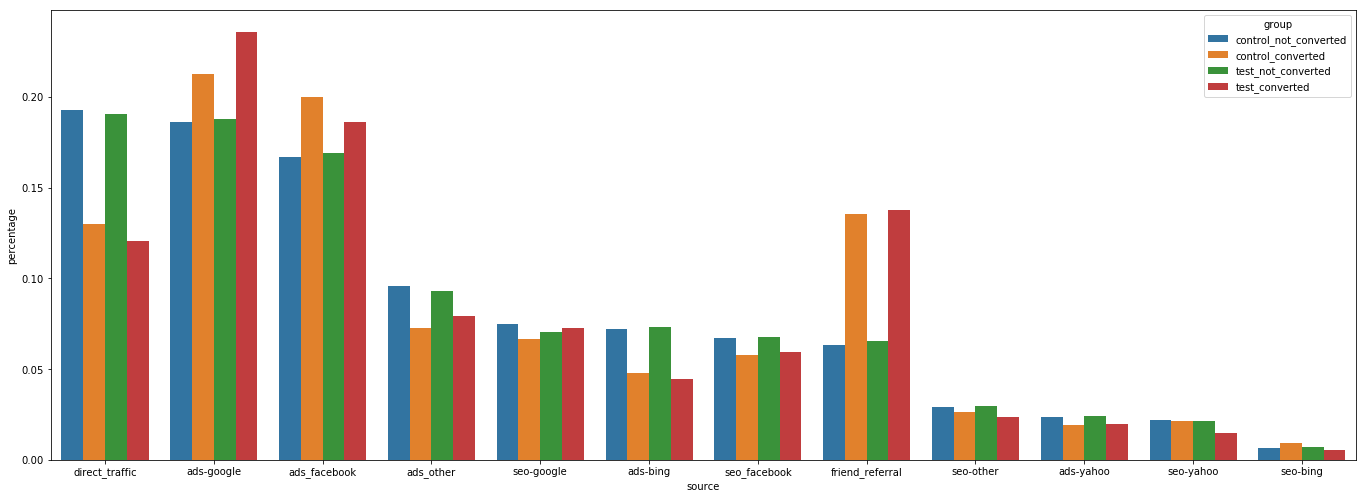

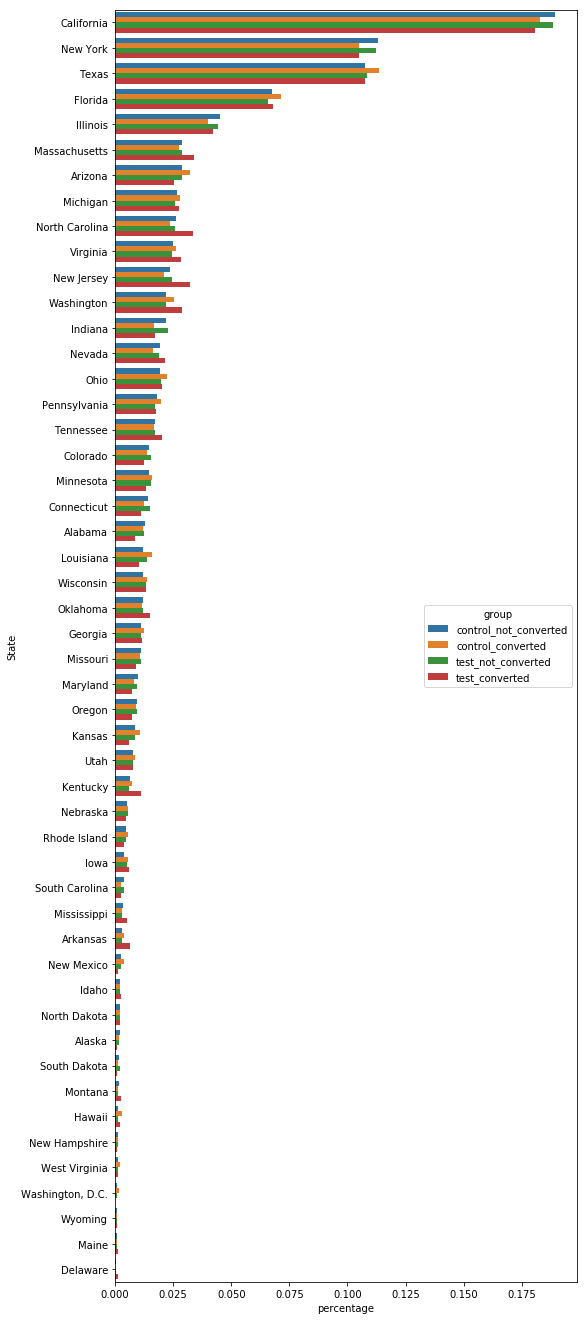

In [26]:
plot_col_bars('source', 'group')
plot_col_bars('State', 'group', True)

# Results of ads / Geography
- Friend referral particularly high
- direct traffic somewhat low. 
- Google ads seem to do better with higher price, 
- facebook with lower price
- Bing underperforming
- People don't seem to be searching for them as much as landing via ads

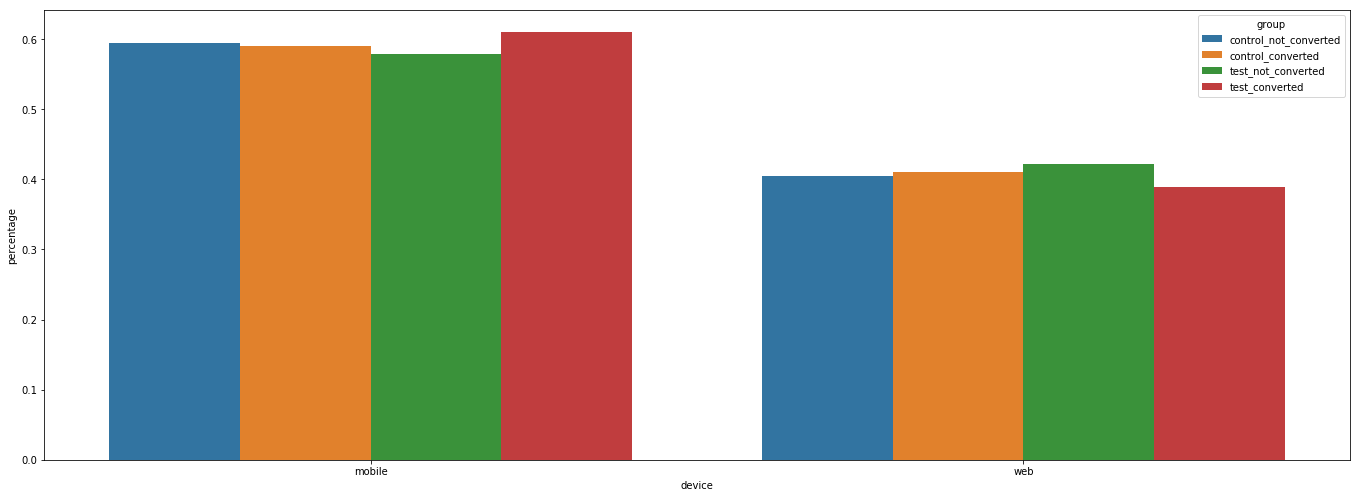

In [27]:
plot_col_bars('device', 'group')

# Mobile somewhat more common than web, but both are important

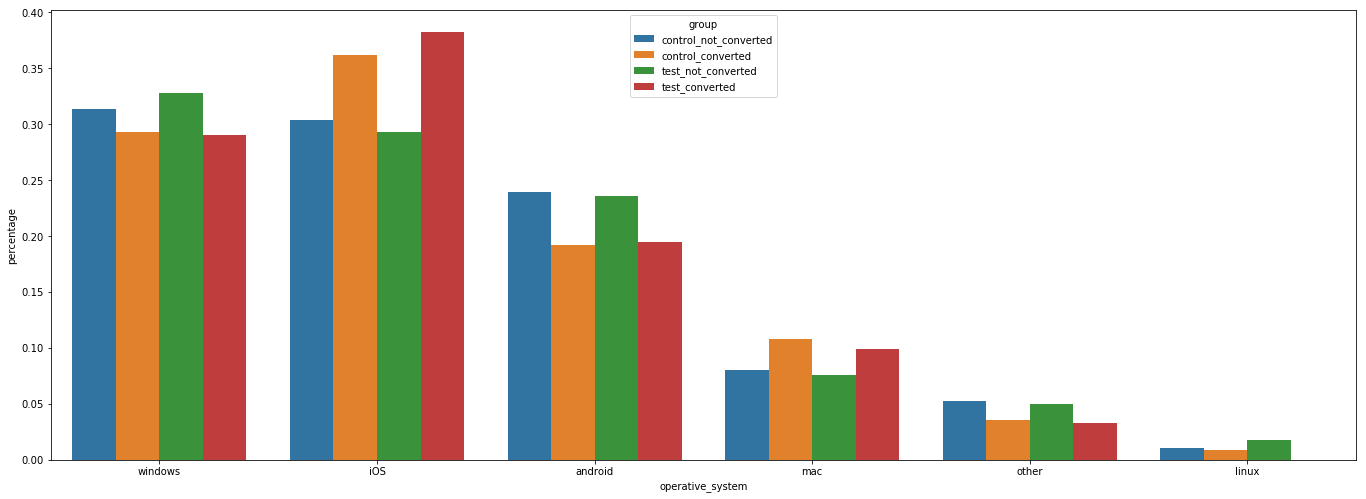

In [28]:
plot_col_bars('operative_system', 'group')

# Operating system user demographics impact outcomes
- IOS users seem to prefer higher prices
- Mac users slighty more sensitive to price
- zero linux users purchased at higher price, but given low exposure to linux compared to other groups, hard to tell if significant

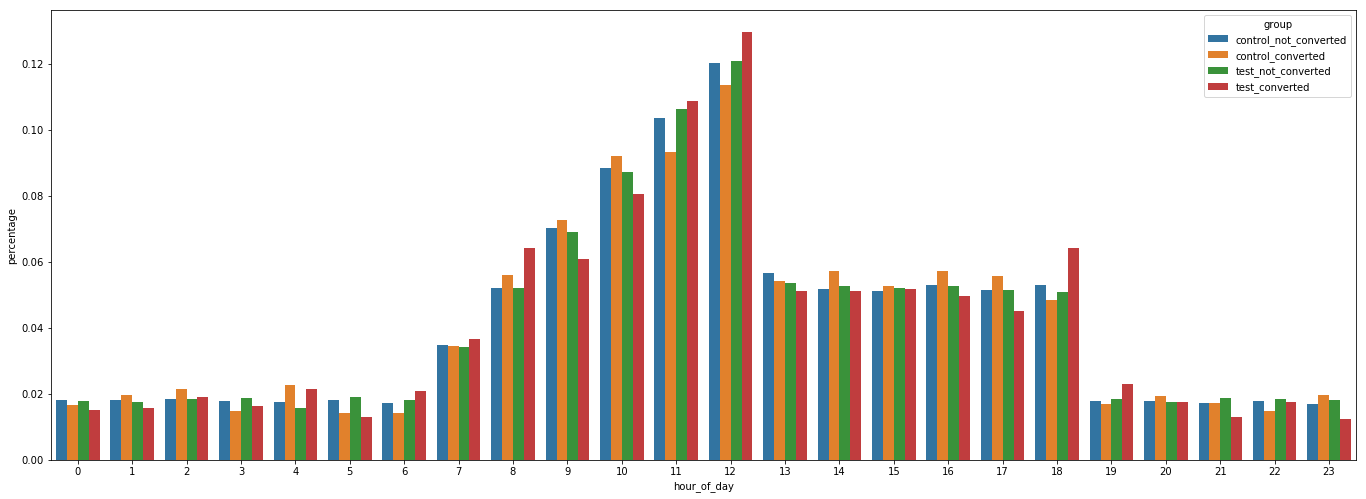

In [29]:
plot_col_bars('hour_of_day', 'group')

# Hours of the day affect traffic and conversion rate
- Users seem increasingly drawn to site in morning until lunch 
- After lunch, interest dips and remains flat until dinner
- Still higher than after dinner and until next morning
- Seems to be a peak in purchasing just before lunch and just before dinner.

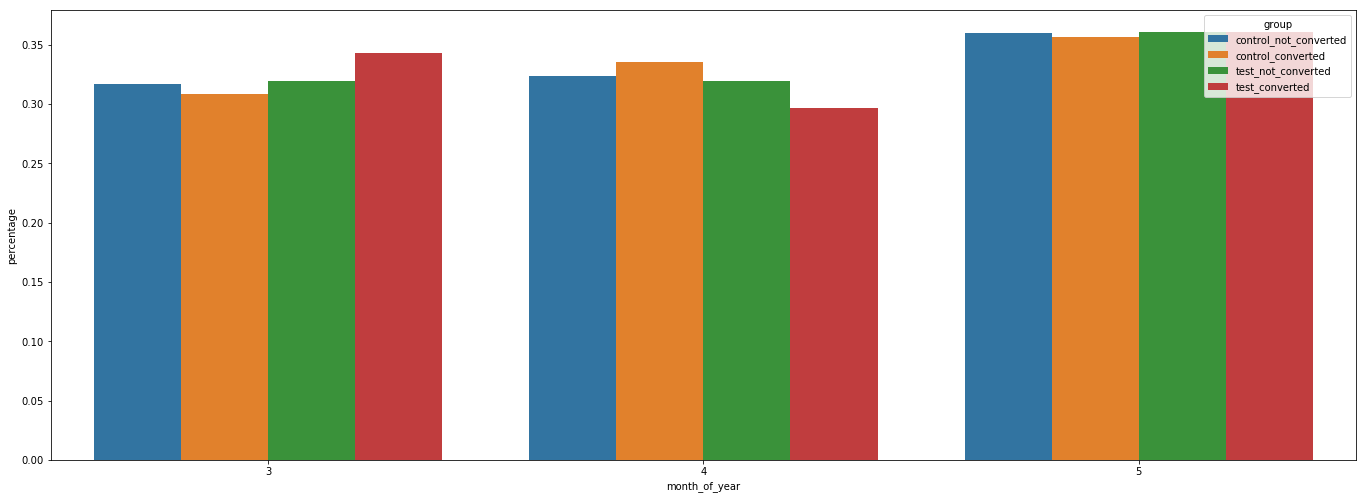

In [30]:
plot_col_bars('month_of_year', 'group')

# Response seems to vary month to month